<a href="https://colab.research.google.com/github/moharamfatema/modulation-classification/blob/main/modulation_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [1]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gc

ROOT = '/content/drive/MyDrive/datasets/deepsig/RML2016.10b'
OUT = '/content/drive/MyDrive/out/rml/checkpoints'
DAT = ROOT + '/RML2016.10b.dat'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
X = np.moveaxis(X, 1, -1)
X = X / np.max(X)
y = np.array(lbl)
del lbl
gc.collect()
X.shape, y.shape

((1200000, 128, 2), (1200000, 2))

In [4]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

In [5]:
EPOCHS = 100
PATIENCE = 6
LEARNING_RATE = 0.0009

X = X[:,:,np.newaxis,:]

In [6]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [7]:
values = np.linspace(0.00001,LEARNING_RATE,10)[::-1]
boundaries = np.linspace(5, 100,9)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [8]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS,batch_size=512):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val,y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [9]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
        print(f'Accuracy at SNR = {snr} is {round(accuracies[i],2)} %')
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

# Loading and exploring the data

In [ ]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
X = np.moveaxis(X, 1, -1)
X = X / np.max(X)
y = np.array(lbl)
del lbl
gc.collect()
X.shape, y.shape

In [ ]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

In [ ]:
plt.plot(X[0,:,0])
plt.plot(X[0,:,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

## Signal derivative

In [ ]:
d_np = np.gradient(X[0,:,0])

lines=[d_np,X[0,:,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

## Signal Integral

In [ ]:
i_ct = cumulative_trapezoid(X[0,:,0])

lines=[i_ct,X[0,:,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

# Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [ ]:
'''X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X,X_diff),axis=1)
X_raw_int = np.concatenate((X,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')'''

"X_diff = np.gradient(X,axis=-1)\nX_int = np.zeros_like(X)\nX_int[:,:,:-1] = np.array(cumulative_trapezoid(X))\n\nX_raw_diff = np.concatenate((X,X_diff),axis=1)\nX_raw_int = np.concatenate((X,X_int),axis=1)\nX_diff_int = np.concatenate((X_diff,X_int),axis=1)\n\nX_all = np.concatenate((X,X_diff,X_int),axis=1)\n\nprint(f'Shapes\nX_raw: {X.shape}\nX_diff: {X_diff.shape}\nX_int: {X_int.shape}\n\nX_raw_diff: {X_raw_diff.shape}\nX_raw_int: {X_raw_int.shape}\nX_diff_int: {X_diff_int.shape}\n\nX_all: {X_all.shape}')"

In [ ]:
'''del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all'''

'del X_diff\ndel X_int\n\ndel X_raw_diff\ndel X_raw_int\ndel X_diff_int\n\ndel X_all'

# Data Splitting

In [ ]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

# Models

## Hyperparameters

In [ ]:
EPOCHS = 100
PATIENCE = 6
LEARNING_RATE = 0.0009

X = X[:,:,np.newaxis,:]

## CNN model

In [ ]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [ ]:
x = X
cnn_model = create_cnn("cnn_2_ch",x.shape[1:])

Model: "cnn_2_ch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 1, 64)        1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 1, 16)         9232      
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 142,938
Trainable params: 142,938
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
values = np.linspace(0.00001,LEARNING_RATE,10)[::-1]
boundaries = np.linspace(5, 100,9)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [ ]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS,batch_size=512):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val,y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

In [ ]:
! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_raw
RAW_CHK = OUT + '/cnn_raw/checkpoint.h5'


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.6409 - accuracy: 0.3481 - val_loss: 1.3894 - val_accuracy: 0.4434 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.2619 - accuracy: 0.4830 - val_loss: 1.1982 - val_accuracy: 0.5020 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.1660 - accuracy: 0.5162 - val_loss: 1.1569 - val_accuracy: 0.5254 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.1346 - accuracy: 0.5297 - val_loss: 1.1267 - val_accuracy: 0.5276 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 [

[1.070104956626892, 0.5563809275627136]

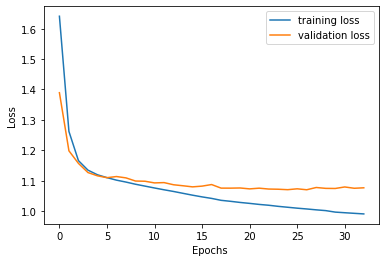

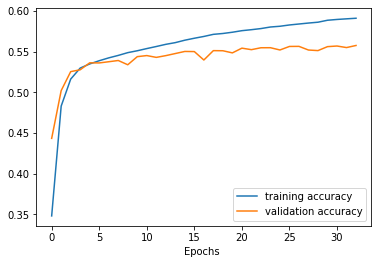

In [ ]:
cnn_history = train_and_plot(
    cnn_model,
    RAW_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_model.load_weights(RAW_CHK)
cnn_model.evaluate(x_val,y_val_encoded)

In [ ]:
cnn_model.load_weights(RAW_CHK)
cnn_model.evaluate(x_val,y_val_encoded)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.0701 - accuracy: 0.5564


[1.070104956626892, 0.5563809275627136]

## Test Results

In [ ]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

11250/11250 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.57      0.54      0.55     36000
      AM-DSB       0.51      0.69      0.59     36000
        BPSK       0.55      0.65      0.59     36000
       CPFSK       0.60      0.64      0.62     36000
        GFSK       0.51      0.69      0.59     36000
        PAM4       0.77      0.70      0.73     36000
       QAM16       0.46      0.32      0.38     36000
       QAM64       0.54      0.45      0.49     36000
        QPSK       0.52      0.55      0.53     36000
        WBFM       0.50      0.31      0.38     36000

    accuracy                           0.55    360000
   macro avg       0.55      0.55      0.55    360000
weighted avg       0.55      0.55      0.55    360000



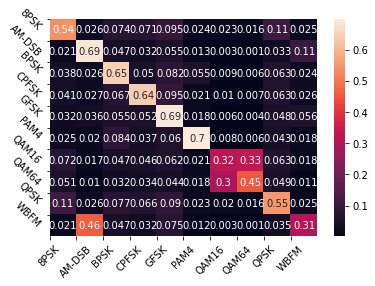

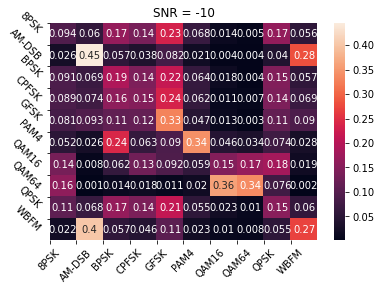

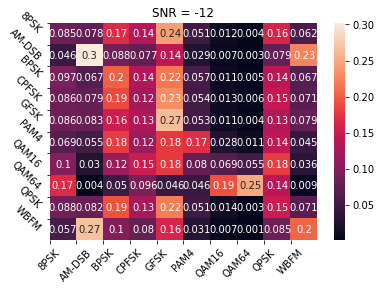

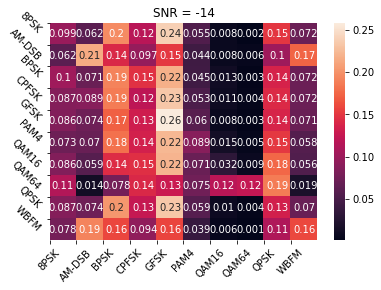

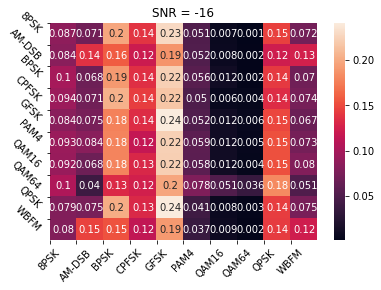

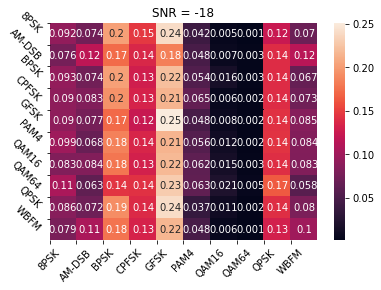

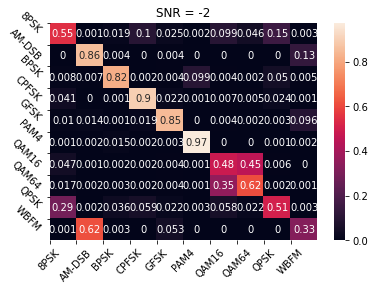

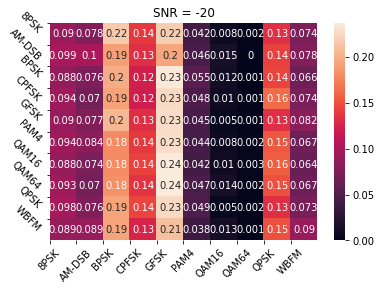

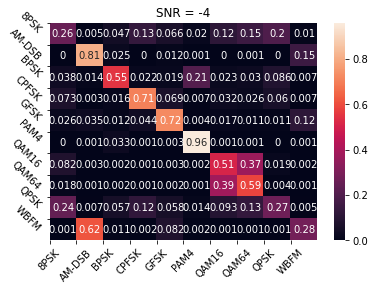

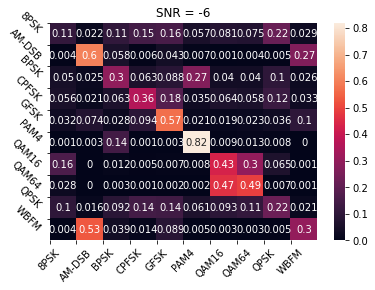

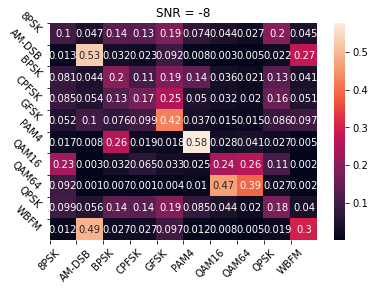

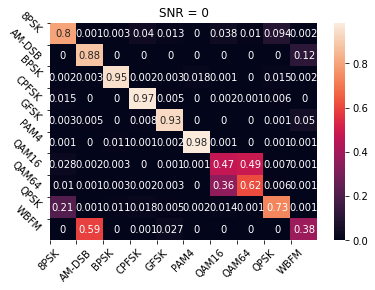

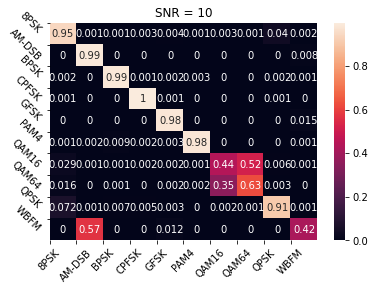

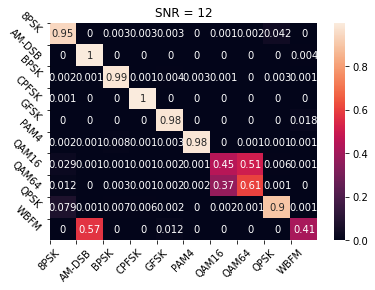

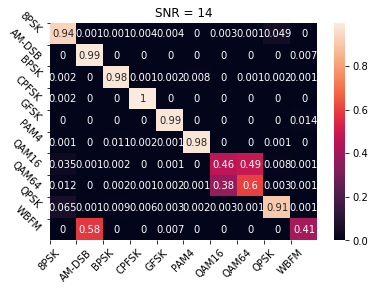

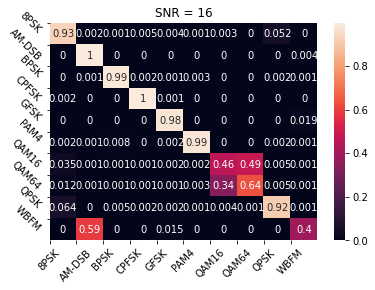

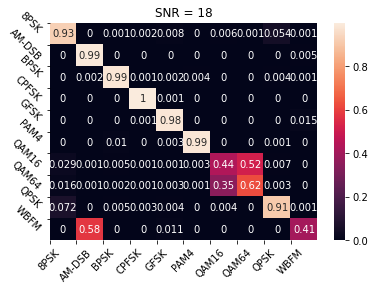

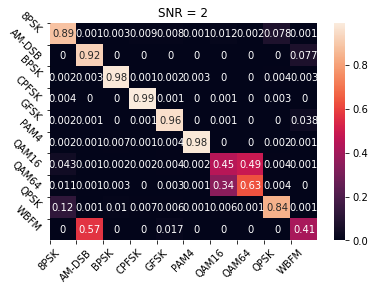

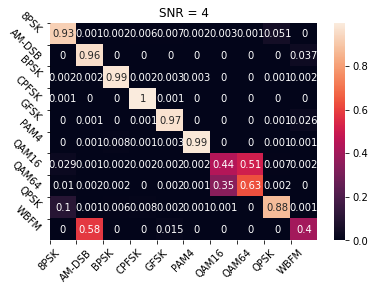

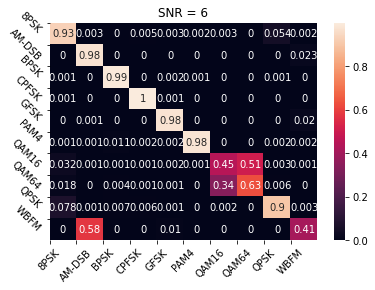

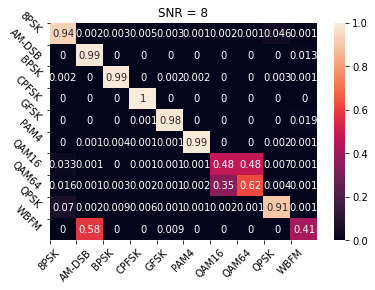

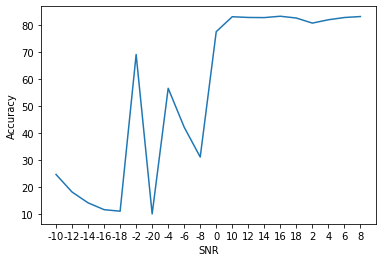

In [ ]:
eval_model(cnn_model,x_test,y_test,y_test_encoded)

### CNN on X diff

In [ ]:
x = np.gradient(X,axis=-1)
cnn_diff_model = create_cnn("cnn_diff",x.shape[1:])

Model: "cnn_diff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 1, 64)        1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 1, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         9232      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 1, 16)        64        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
# ! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_diff
OUT = '/content/drive/MyDrive/out/rml/checkpoints'
DIFF_CHK = OUT + '/cnn_diff/checkpoint.h5'


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 21s 8ms/step - loss: 1.4616 - accuracy: 0.4144 - val_loss: 1.4549 - val_accuracy: 0.4243 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 13s 8ms/step - loss: 1.3202 - accuracy: 0.4644 - val_loss: 1.3483 - val_accuracy: 0.4518 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 15s 10ms/step - loss: 1.2818 - accuracy: 0.4780 - val_loss: 1.3261 - val_accuracy: 0.4667 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.2605 - accuracy: 0.4860 - val_loss: 1.2785 - val_accuracy: 0.4776 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 

[1.2671178579330444, 0.4891904890537262]

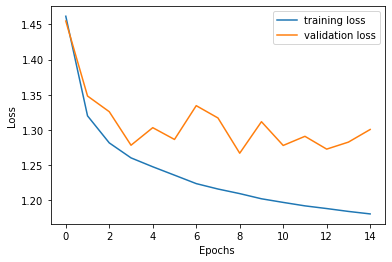

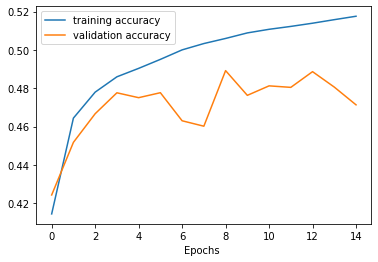

In [ ]:
cnn_diff_history = train_and_plot(
    cnn_diff_model,
    DIFF_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

cnn_diff_model.load_weights(DIFF_CHK)
cnn_diff_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.29      0.57      0.38     36000
      AM-DSB       0.44      0.75      0.55     36000
        BPSK       0.60      0.56      0.58     36000
       CPFSK       0.52      0.63      0.57     36000
        GFSK       0.62      0.65      0.63     36000
        PAM4       0.80      0.47      0.59     36000
       QAM16       0.31      0.07      0.12     36000
       QAM64       0.48      0.58      0.53     36000
        QPSK       0.52      0.38      0.44     36000
        WBFM       0.64      0.22      0.33     36000

    accuracy                           0.49    360000
   macro avg       0.52      0.49      0.47    360000
weighted avg       0.52      0.49      0.47    360000



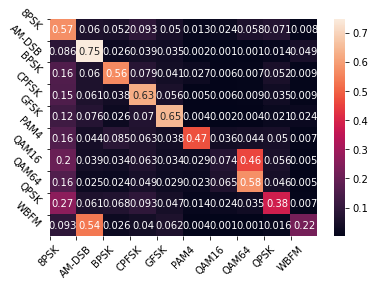

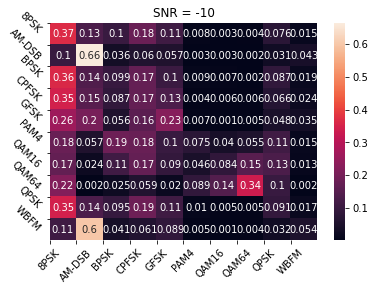

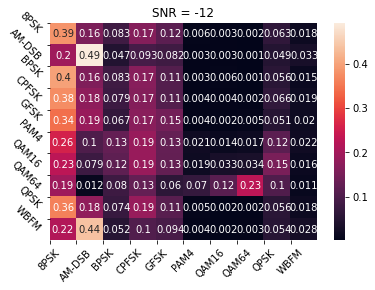

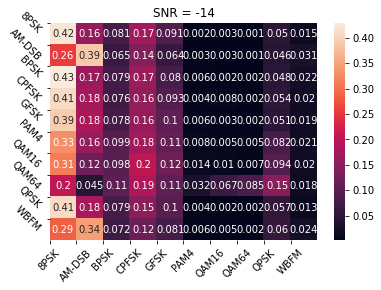

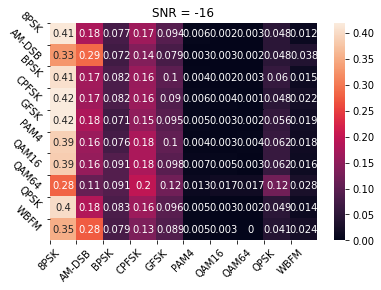

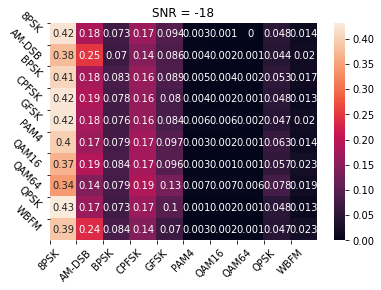

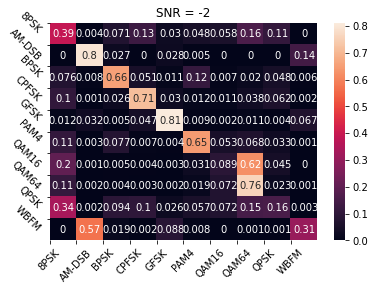

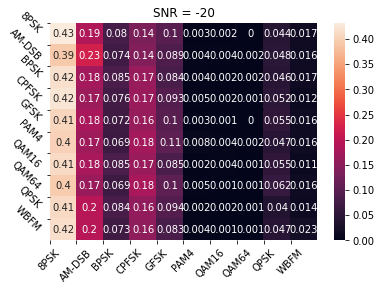

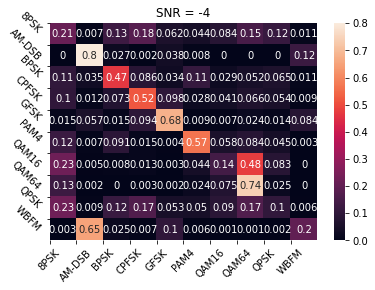

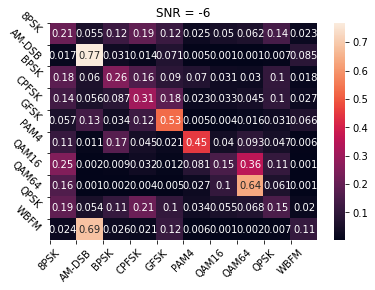

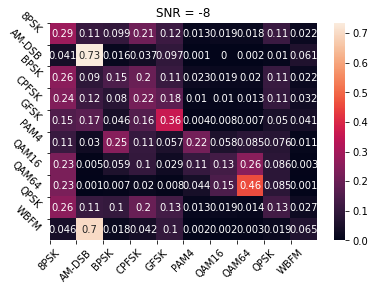

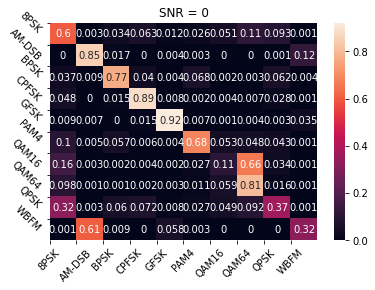

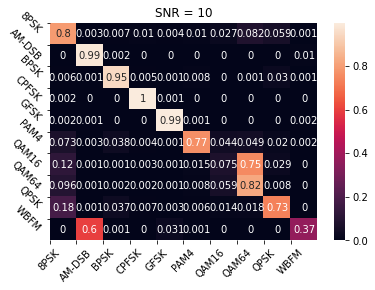

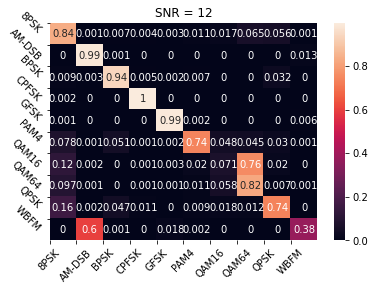

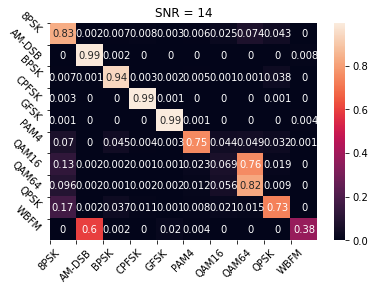

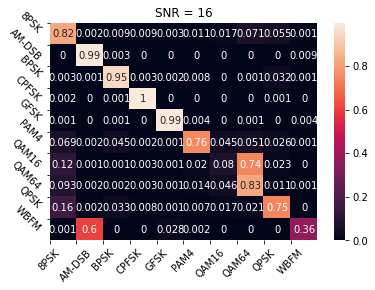

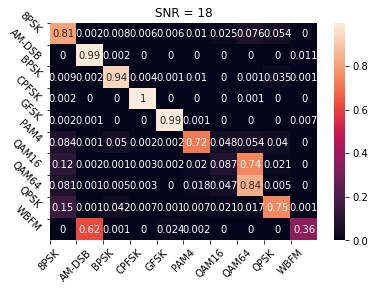

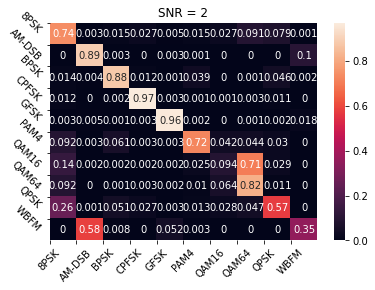

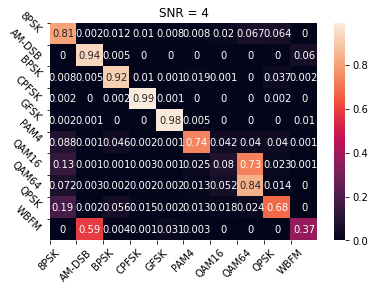

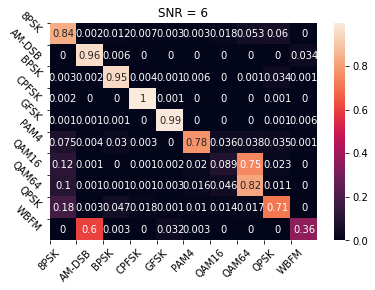

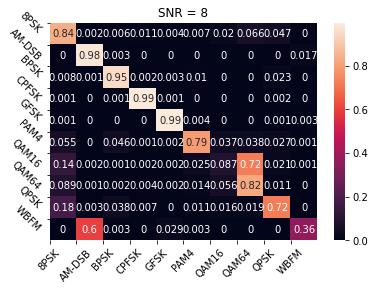

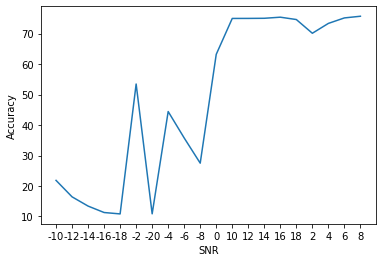

In [ ]:
eval_model(cnn_diff_model,x_test,y_test,y_test_encoded)

## Integrated Signal model

In [10]:
# OUT = '/content/drive/MyDrive/out/rml/checkpoints'
INT_CHK = OUT + '/cnn_int/checkpoint.h5'

In [11]:
# del x_train, x_val, x_test, y_train, y_val, y_test, cnn_int_model
for _ in range (100):
    gc.collect()

In [11]:
x = np.zeros_like(X)
x[:,:-1,:,:] = cumulative_trapezoid(X,axis=1)
SNR = np.array(y[:,1]).astype(int)[:,np.newaxis,np.newaxis,np.newaxis].repeat(2,axis=-1)
x = np.concatenate((x,SNR),axis=1)
x.shape

x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x, X

encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape


(360000, 10)

In [12]:
cnn_int_model = create_cnn("cnn_int",x_train.shape[1:])

Model: "cnn_int"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 129, 1, 64)        1216      
                                                                 
 batch_normalization (BatchN  (None, 129, 1, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 1, 16)         9232      
                                                                 
 batch_normalization_1 (Batc  (None, 65, 1, 16)        64        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1040)              0         
                                                                 
 dense (Dense)               (None, 128)               1332


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 23s 9ms/step - loss: 1.6142 - accuracy: 0.3484 - val_loss: 1.4650 - val_accuracy: 0.3988 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.4354 - accuracy: 0.4135 - val_loss: 1.4164 - val_accuracy: 0.4205 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.3639 - accuracy: 0.4422 - val_loss: 1.3465 - val_accuracy: 0.4478 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.2890 - accuracy: 0.4702 - val_loss: 1.2766 - val_accuracy: 0.4726 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 [

[0.9589877128601074, 0.5934047698974609]

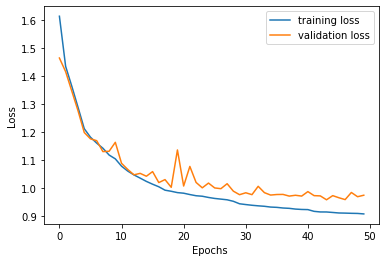

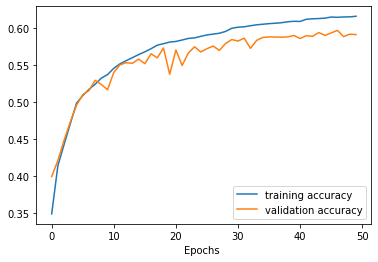

In [13]:
# cnn_int_model.load_weights(INT_CHK)

cnn_int_history = train_and_plot(
    cnn_int_model,
    INT_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS,
    batch_size=512
)
del x_train
cnn_int_model.load_weights(INT_CHK)

cnn_int_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.58      0.52      0.55     36000
      AM-DSB       0.47      0.61      0.53     36000
        BPSK       0.77      0.65      0.70     36000
       CPFSK       0.74      0.62      0.68     36000
        GFSK       0.71      0.67      0.69     36000
        PAM4       0.80      0.73      0.76     36000
       QAM16       0.41      0.53      0.46     36000
       QAM64       0.47      0.65      0.55     36000
        QPSK       0.65      0.53      0.58     36000
        WBFM       0.54      0.43      0.48     36000

    accuracy                           0.59    360000
   macro avg       0.61      0.59      0.60    360000
weighted avg       0.61      0.59      0.60    360000



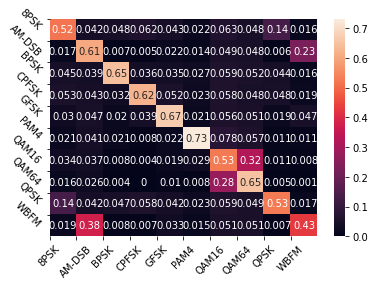

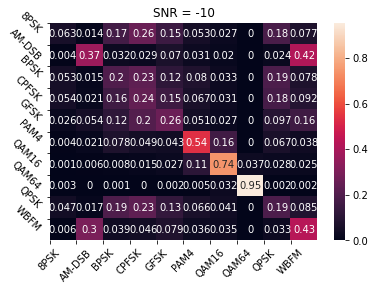

Accuracy at SNR = -10 is 0.4000000059604645 %


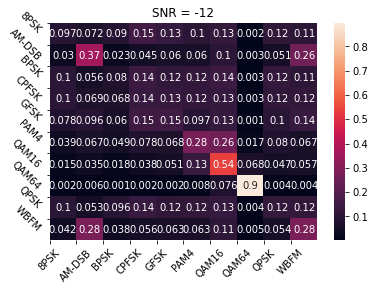

Accuracy at SNR = -12 is 0.28999999165534973 %


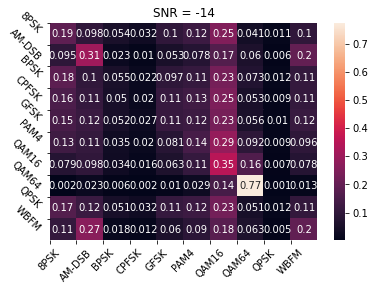

Accuracy at SNR = -14 is 0.2199999988079071 %


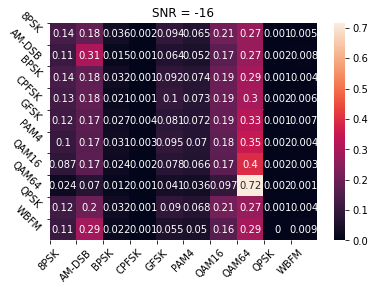

Accuracy at SNR = -16 is 0.15000000596046448 %


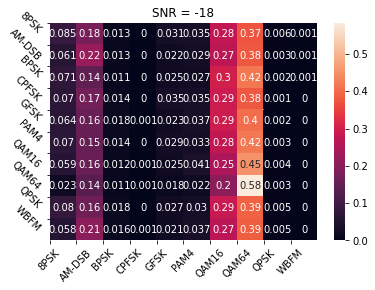

Accuracy at SNR = -18 is 0.11999999731779099 %


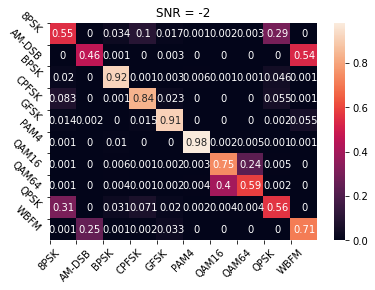

Accuracy at SNR = -2 is 0.7300000190734863 %


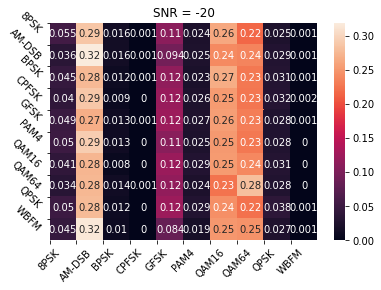

Accuracy at SNR = -20 is 0.10999999940395355 %


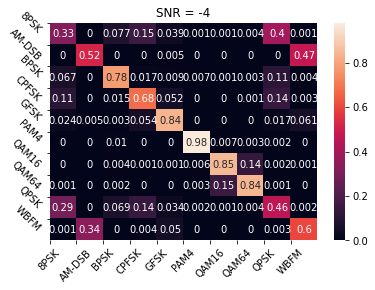

Accuracy at SNR = -4 is 0.6899999976158142 %


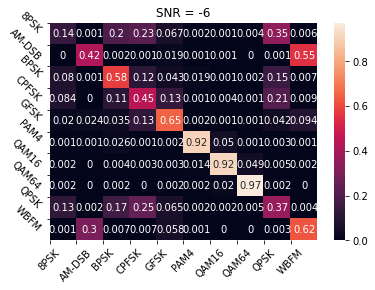

Accuracy at SNR = -6 is 0.6100000143051147 %


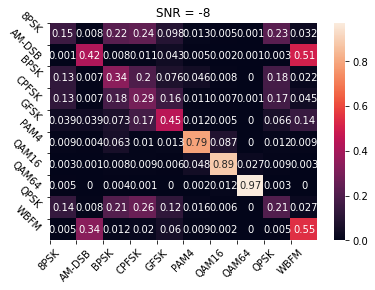

Accuracy at SNR = -8 is 0.5099999904632568 %


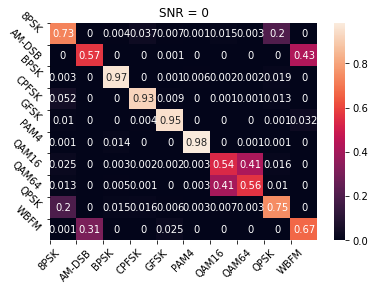

Accuracy at SNR = 0 is 0.7699999809265137 %


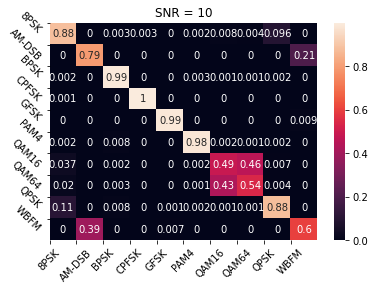

Accuracy at SNR = 10 is 0.8199999928474426 %


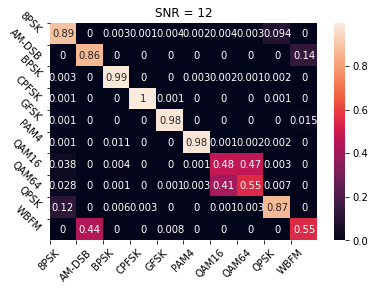

Accuracy at SNR = 12 is 0.8199999928474426 %


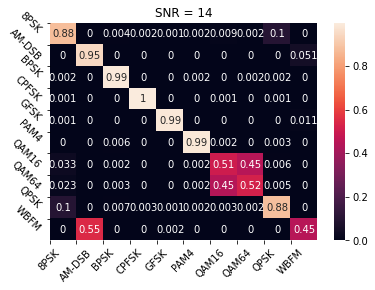

Accuracy at SNR = 14 is 0.8199999928474426 %


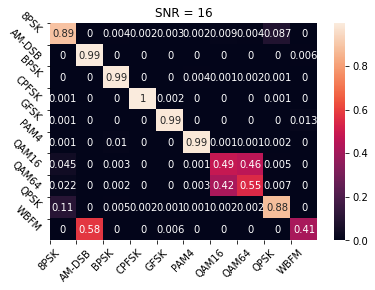

Accuracy at SNR = 16 is 0.8199999928474426 %


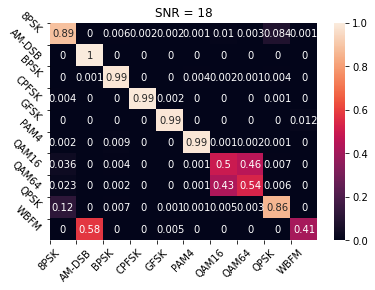

Accuracy at SNR = 18 is 0.8100000023841858 %


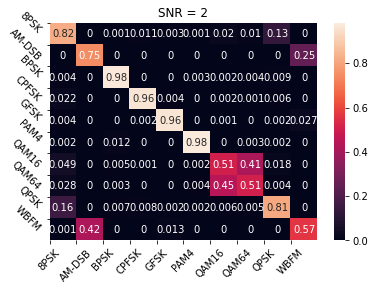

Accuracy at SNR = 2 is 0.7900000214576721 %


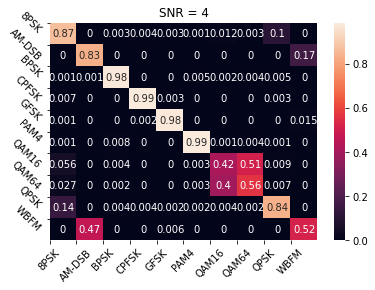

Accuracy at SNR = 4 is 0.800000011920929 %


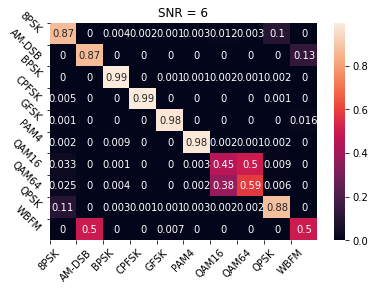

Accuracy at SNR = 6 is 0.8100000023841858 %


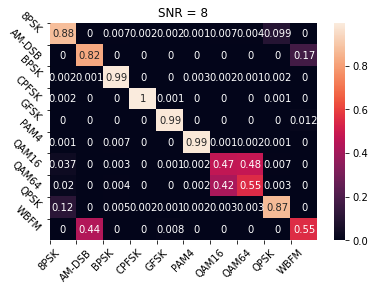

Accuracy at SNR = 8 is 0.8100000023841858 %


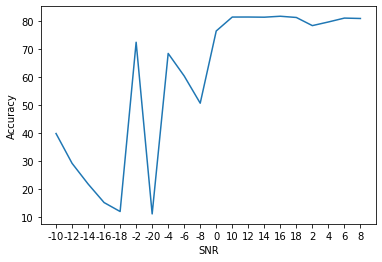

In [14]:
eval_model(cnn_int_model,x_test,y_test,y_test_encoded)

## Combination : all

In [ ]:
X.shape

(1200000, 128, 1, 2)

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(X,y)


In [ ]:
# del X, y
gc.collect()

0

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

In [ ]:
del X,x_train, x_val, y_train, y_val

In [ ]:
x_diff = np.gradient(X,axis=-1)
x_int = np.zeros_like(X)
x_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

x = np.concatenate((X,x_diff,x_int),axis=1)

del x_diff, x_int
gc.collect()

In [ ]:
X_embed_int = np.concatenate((x,y[:,1][:,np.newaxis,:].repeat(2,-1)),axis=1)
X_embed_int.shape

In [ ]:
OUT = '/content/drive/MyDrive/out/rml/checkpoints'

ALL_CHK = OUT + '/cnn_all/checkpoint.h5'

In [ ]:
cnn_all_model = create_cnn("cnn_all",x_test.shape[1:])


# gc.collect()

# encoder = OneHotEncoder(sparse=False)
# encoder.fit(y_test[:,0].reshape(-1,1))
# y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))

# y_test_encoded.shape

Model: "cnn_all"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 1, 64)        1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 1, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         9232      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 1, 16)        64        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               1312


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 22s 9ms/step - loss: 1.2301 - accuracy: 0.4893 - val_loss: 1.1439 - val_accuracy: 0.5187 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 13s 8ms/step - loss: 1.0848 - accuracy: 0.5448 - val_loss: 1.1283 - val_accuracy: 0.5333 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 13s 8ms/step - loss: 1.0416 - accuracy: 0.5620 - val_loss: 1.0498 - val_accuracy: 0.5579 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 13s 8ms/step - loss: 1.0142 - accuracy: 0.5748 - val_loss: 1.0634 - val_accuracy: 0.5466 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 [

[1.0185014009475708, 0.586904764175415]

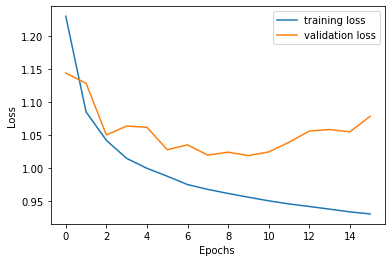

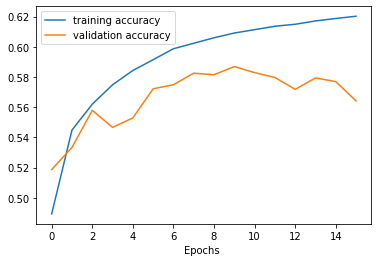

In [ ]:


cnn_all_history = train_and_plot(
    cnn_all_model,
    ALL_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS,
    batch_size=512
)
del x_train

cnn_all_model.load_weights(ALL_CHK)
cnn_all_model.evaluate(x_val,y_val_encoded)

In [ ]:
cnn_all_model.load_weights(ALL_CHK)


11250/11250 [==============================] - 20s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.70      0.52      0.60     36000
      AM-DSB       0.47      0.75      0.58     36000
        BPSK       0.54      0.67      0.60     36000
       CPFSK       0.74      0.64      0.68     36000
        GFSK       0.57      0.71      0.63     36000
        PAM4       0.82      0.71      0.76     36000
       QAM16       0.59      0.48      0.53     36000
       QAM64       0.64      0.51      0.56     36000
        QPSK       0.47      0.59      0.52     36000
        WBFM       0.51      0.29      0.37     36000

    accuracy                           0.59    360000
   macro avg       0.60      0.59      0.58    360000
weighted avg       0.60      0.59      0.58    360000



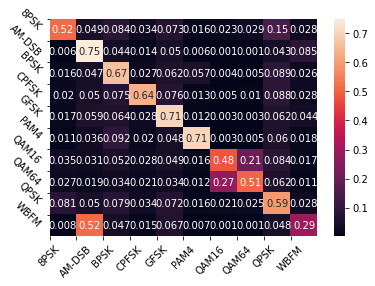

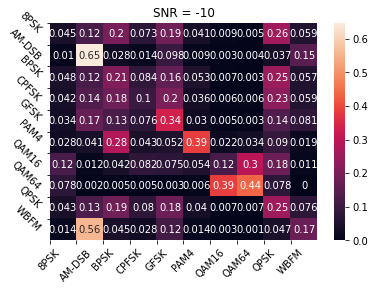

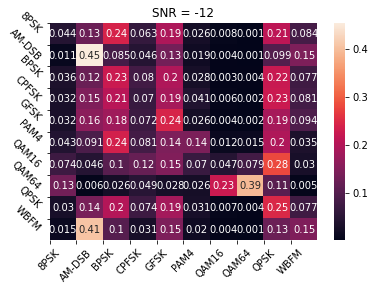

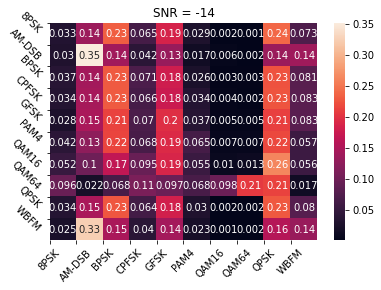

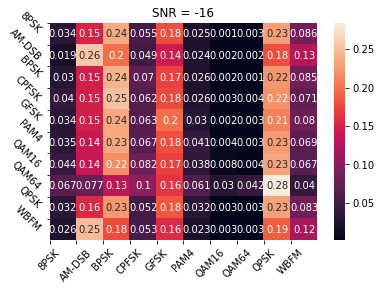

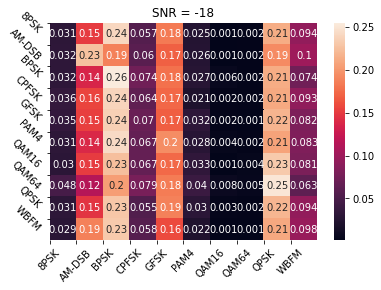

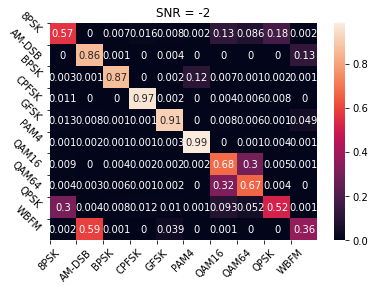

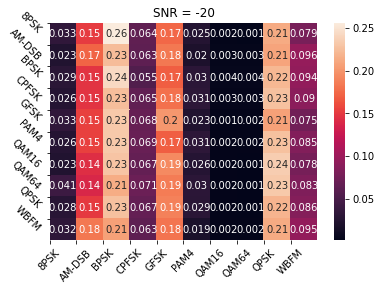

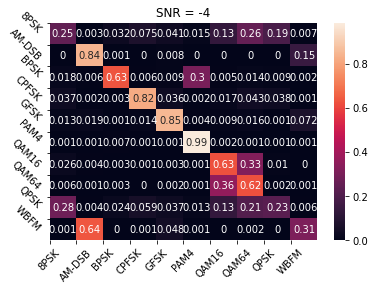

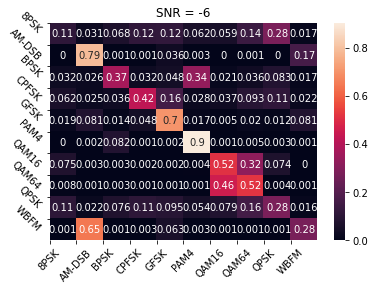

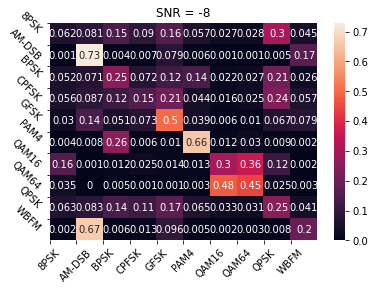

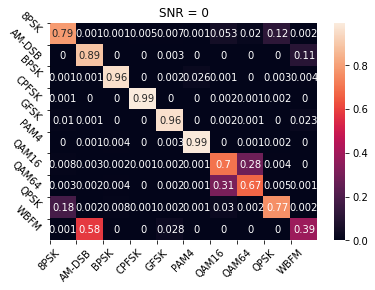

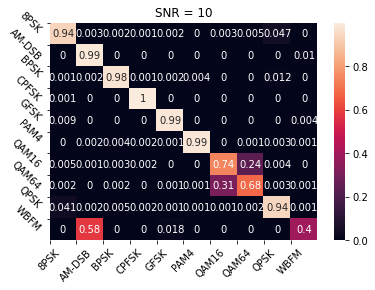

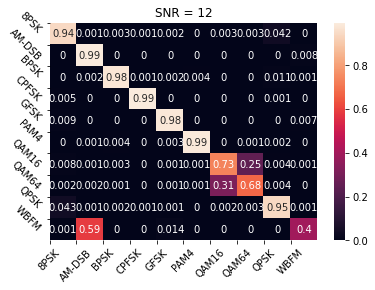

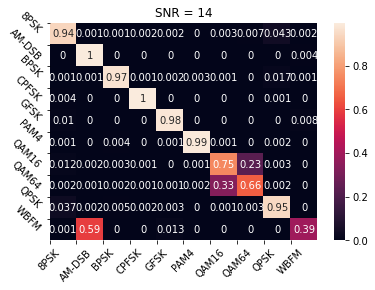

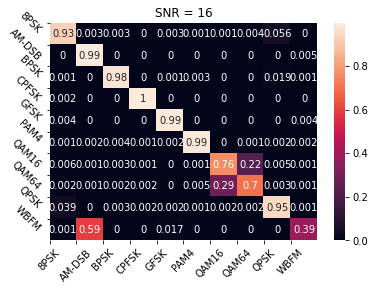

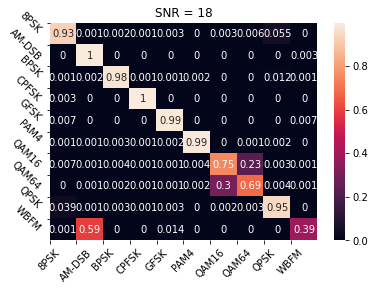

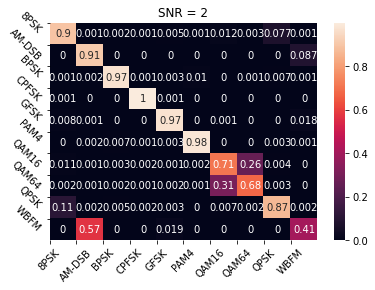

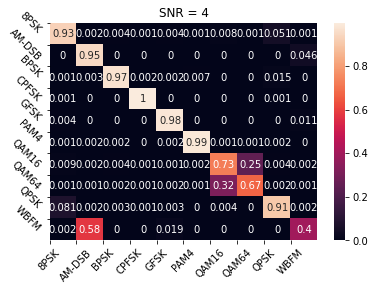

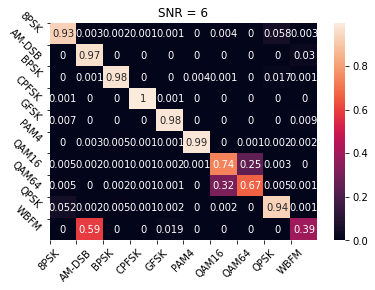

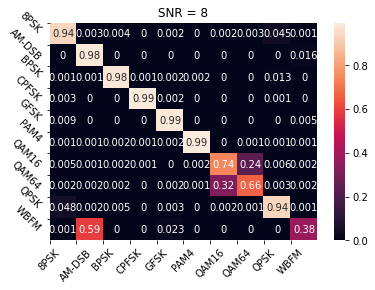

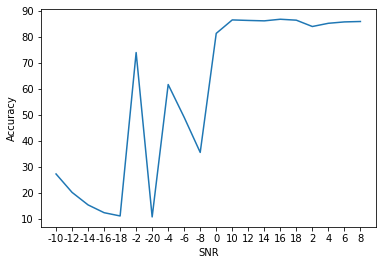

In [ ]:
eval_model(cnn_all_model,x_test,y_test,y_test_encoded)

## Embedding SNR with the input

In [ ]:
del SNR
gc.collect()

30

In [14]:
SNR = np.array(y[:,1]).astype(int)[:,np.newaxis,np.newaxis,np.newaxis].repeat(2,axis=-1)
SNR[0]

array([[[-20, -20]]])

In [15]:
SNR.shape

(1200000, 1, 1, 2)

In [ ]:
X_embed = np.concatenate((X,SNR),axis=1)
X_embed.shape

In [ ]:
! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_embed
EMBED_CHK = OUT + '/cnn_embed/checkpoint.h5'

In [ ]:
cnn_embed_model = create_cnn("cnn_embed",X_embed.shape[1:])

Model: "cnn_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 129, 1, 64)        1216      
                                                                 
 batch_normalization (BatchN  (None, 129, 1, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 1, 16)         9232      
                                                                 
 batch_normalization_1 (Batc  (None, 65, 1, 16)        64        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1040)              0         
                                                                 
 dense (Dense)               (None, 128)               13

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(X_embed,y)
del X_embed, y 
gc.collect()

encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 20s 8ms/step - loss: 1.2565 - accuracy: 0.4875 - val_loss: 1.7319 - val_accuracy: 0.4163 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.0359 - accuracy: 0.5707 - val_loss: 1.2350 - val_accuracy: 0.5180 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 12s 8ms/step - loss: 0.9679 - accuracy: 0.5974 - val_loss: 1.1398 - val_accuracy: 0.5456 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 14s 9ms/step - loss: 0.9382 - accuracy: 0.6089 - val_loss: 1.0316 - val_accuracy: 0.5778 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 [

[0.9031774401664734, 0.6265714168548584]

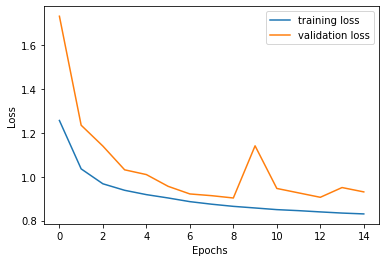

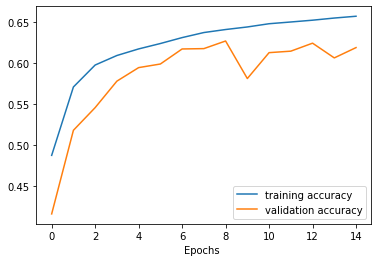

In [ ]:
cnn_embed_history = train_and_plot(
    cnn_embed_model,
    EMBED_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_embed_model.load_weights(EMBED_CHK)
cnn_embed_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 21s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.62      0.52      0.57     36000
      AM-DSB       0.48      0.77      0.59     36000
        BPSK       0.58      0.71      0.64     36000
       CPFSK       0.79      0.65      0.71     36000
        GFSK       0.81      0.65      0.72     36000
        PAM4       0.87      0.74      0.80     36000
       QAM16       0.60      0.57      0.58     36000
       QAM64       0.51      0.82      0.63     36000
        QPSK       0.66      0.56      0.61     36000
        WBFM       0.60      0.29      0.39     36000

    accuracy                           0.63    360000
   macro avg       0.65      0.63      0.62    360000
weighted avg       0.65      0.63      0.62    360000



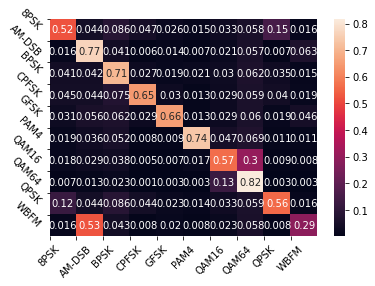

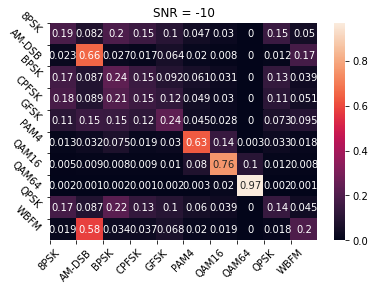

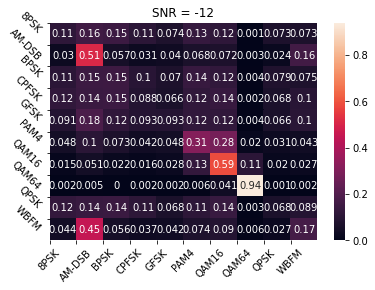

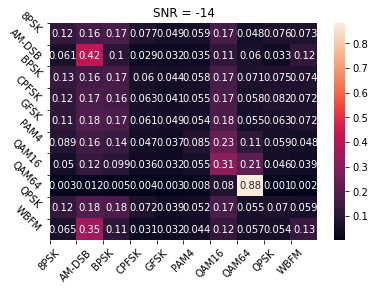

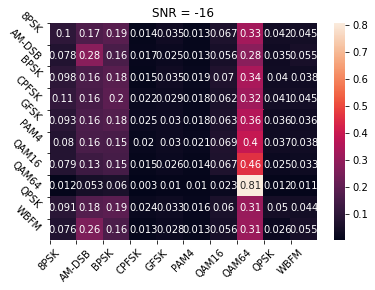

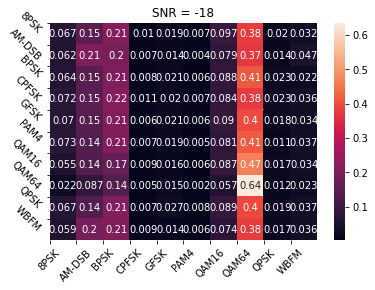

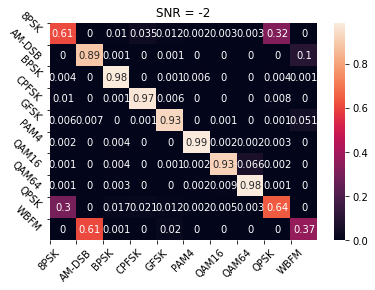

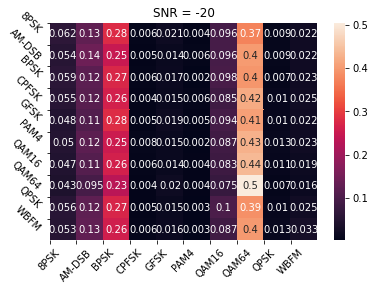

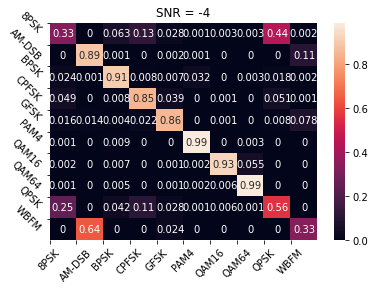

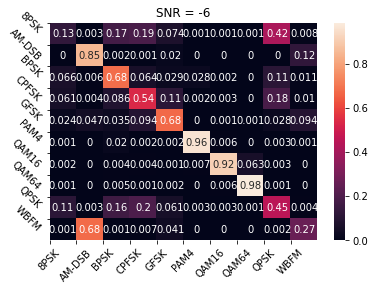

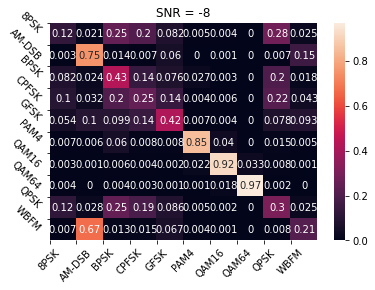

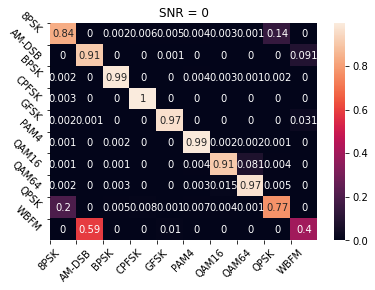

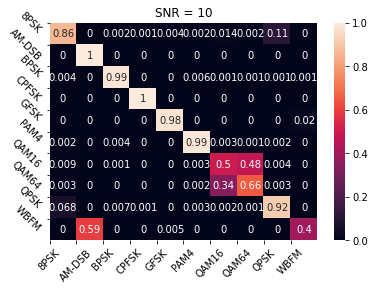

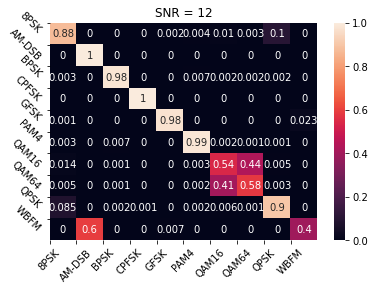

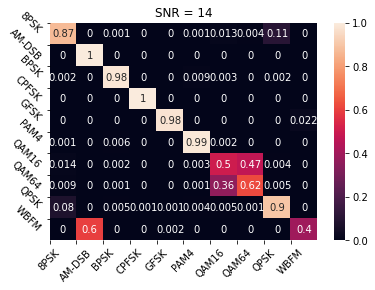

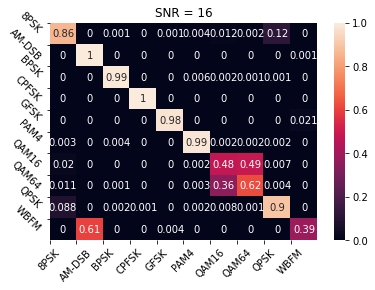

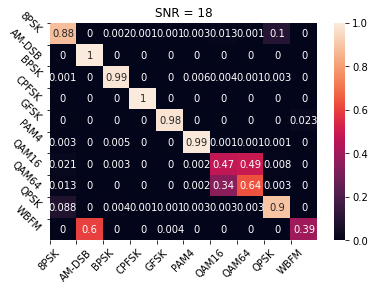

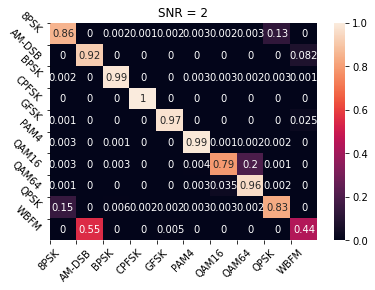

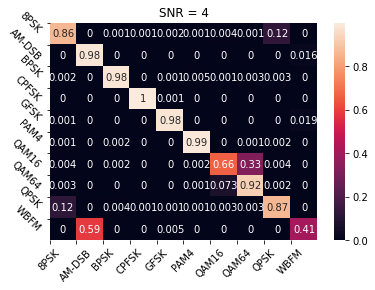

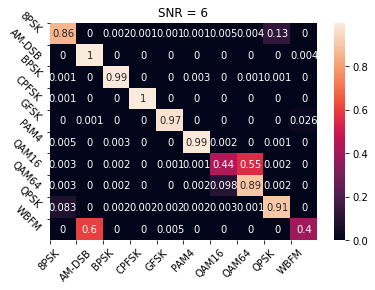

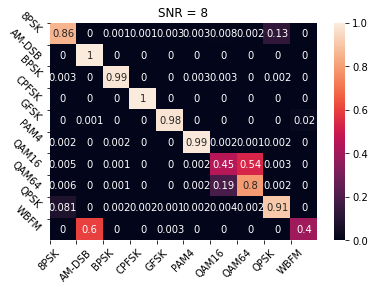

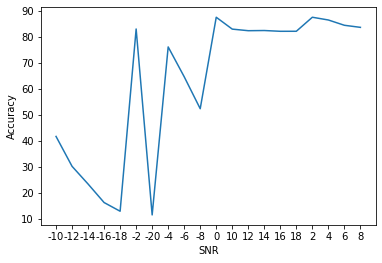

In [ ]:
eval_model(cnn_embed_model,x_test,y_test,y_test_encoded)